<a href="https://colab.research.google.com/github/Zernach/DS-Unit-2-Kaggle-Challenge/blob/master/221_ZERNACH_%E2%80%94_Tanzania_Kaggle_Challenge_1_(Monday%2C_November_4th_2019).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ASSIGNMENT COMPLETED BY: [RYAN ZERNACH](http://ryan.zernach.com/portfolio/)

![alt text](http://www.zernach.com/wp-content/uploads/2019/09/Ryan-Zernach-Logo-1-e1568499634499.png)

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [X] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition.
- [X] Do train/validate/test split with the Tanzania Waterpumps data.
- [X] Begin with baselines for classification.
- [X] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [X] Get your validation accuracy score.
- [X] Get and plot your feature importances.
- [X] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [X] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [X] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


# PART 1 -- Setup data. Then, do train/validate/test split with the Tanzania Waterpumps data.

In [1]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    
# If you're working locally:
else:
    DATA_PATH = '../data/'

import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

     |████████████████████████████████| 102kB 2.3MB/s 


((59400, 41), (14358, 40))

In [2]:
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

# PART 2 -- Begin with baselines for classification.

In [3]:
train['status_group'].value_counts(normalize=True)

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

In [0]:
import numpy as np

def wrangle(X):
      X = X.copy()
      X['latitude'] = X['latitude'].replace(-2e-08, 0)
      cols_with_zeros = ['longitude', 'latitude']
      for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
      X = X.drop(columns='quantity_group')
      return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

# PART 3 -- Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.

In [0]:
# Is the water-well functional, non-functional, or functional-but-needs-repair
target = 'status_group'
# Create a variable that contains all columns except target and id
train_features = train.drop(columns=[target, 'id'])
# Using that variable, refine that list of columns to include only numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
# Using that same variable, refine that list of columns to include all other types of features
cardinality = train_features.select_dtypes(exclude='number').nunique()
# If there are less than (or equal to) 50 unique values in each of those columns, add it to categorical_features
categorical_features = cardinality[cardinality <= 100].index.tolist()
# features being used for predictions are numeric and categorical features
features = numeric_features + categorical_features

# Setup x matrices
x_train = train[features]
x_val = val[features]
x_test = test[features]

# Setup y targets
y_train = train[target]
y_val = val[target]

In [8]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestClassifier(random_state=42)
)

pipeline.fit(x_train, y_train);

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


# PART 4 -- Get your validation accuracy score.

In [56]:
print('Train Accuracy', pipeline.score(x_train, y_train))
print('Validation Accuracy', pipeline.score(x_val, y_val))

y_pred = pipeline.predict(x_test)

Train Accuracy 0.9791245791245792
Validation Accuracy 0.797053872053872


# PART 5 -- Get and plot your feature importances.

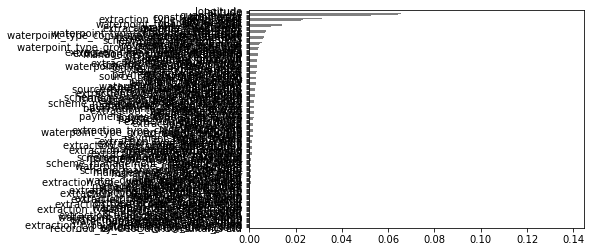

In [62]:
import matplotlib as plt
encoder = pipeline.named_steps['onehotencoder']
model = pipeline.named_steps['randomforestclassifier']
encoded_columns = encoder.transform(x_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
#plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey')

# Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.) Save a copy to github.

In [50]:
pred = pd.Series(y_pred)

id = test['id']
df3 = pd.DataFrame(data = id, columns = ['id', 'status_group'])
df3['status_group'] = pred
df3

,id,status_group
0,50785,non functional
1,51630,functional needs repair
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14353,39307,non functional
14354,18990,functional
14355,28749,functional
14356,33492,functional


In [52]:
from google.colab import drive
drive.mount('drive')
df3.to_csv('DS9_RZernach_Kaggle_Entry_1.csv')
!cp data.csv drive/My\ Drive/

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).
cp: cannot stat 'data.csv': No such file or directory
